# [Swarm behavior on the Grid](https://ecosystem.siemens.com/techforsustainability/swarm-behaviour-on-the-grid/overview)

### Siemens sustainability challenge

blah-blah-blah describe the problem we want to solve

----

# Model demonstration

import packages

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler

%matplotlib inline
pd.set_option('display.max_columns', 500)
sns.set_context('talk', font_scale=1.2)
sns.set_palette('Set1')

## Section 1: data 

### **PJM Hourly Energy Consumption Data**
Dataset: [kaggle link](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption)

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

Raw data have a range of [issues](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption/discussion/175795?select=pjm_hourly_est.csv&sort=votes). A Kaggle user prepared this [gist](https://gist.github.com/ioanpier/e231b22bb9f705ef6280c8b73e40b4a1) for data cleaning which we use here (`process_missing_and_duplicate_timestamps`).

In [61]:
def process_missing_and_duplicate_timestamps(filepath, verbose=False):
    # This gist was created for the Kaggle dataset "Hourly Energy Consumption" which can be found at https://www.kaggle.com/robikscube/hourly-energy-consumption
    # Taking a look at the datasets, one can see that they are sorted by they are sorted by: year asc -> month desc -> day desc -> hour asc
    # There are also missing/duplicate values, which lead to offset by up to a day
    # This method sorts them properly and deals with missing/duplicate values using the averages (of the energy consumption)
    # Returns the processed dataframe

    df = pd.read_csv(filepath)
    df.sort_values('Datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)

    indices_to_remove = []
    series_to_add = []
    hour_counter = 1
    prev_date = ''

    if verbose:
        print(filepath)

    for index, row in df.iterrows():
        date_str = row['Datetime']

        year_str = date_str[0:4]
        month_str = date_str[5:7]
        day_str = date_str[8:10]
        hour_str = date_str[11:13]
        tail_str = date_str[14:]

        def date_to_str():
            return '-'.join([year_str, month_str, day_str]) + ' ' + ':'.join([hour_str, tail_str])
        def date_with_hour(hour):
            hour = '0' + str(hour) if hour < 10 else str(hour)
            return '-'.join([year_str, month_str, day_str]) + ' ' + ':'.join([hour, tail_str])

        if hour_counter != int(hour_str):
            if prev_date == date_to_str():
                # Duplicate datetime, we'll calculate the average and keep only one
                average = int((df.iat[index, 1]+df.iat[index-1, 1])/2)  # Get the average
                df.iat[index, 1] = average
                indices_to_remove.append(index-1)  # Dropping here will offset the index, so we do it after the for-loop
                if verbose:
                    print('Duplicate ' + date_to_str() + ' with average ' + str(average))
            elif hour_counter < 23:
                # Missing datetime, we'll add it using the average of the previous and next for the consumption (MWs)
                average = int((df.iat[index, 1]+df.iat[index-1, 1])/2)

                # Adding here will offset the index, so we do it after the for-loop
                series_to_add.append(pd.Series([date_with_hour(hour_counter), average], index=df.columns))
                if verbose:
                    print('Missing ' + date_with_hour(hour_counter) + ' with average ' + str(average))
            else:
                # Didn't find any such cases in the Hourly Energy Consumption (PJM) (Kaggle) dataset
                # Leaving it for other datasets
                print(date_to_str() + ' and hour_counter ' + str(hour_counter) + " with previous: " + prev_date)

            # Adjust for the missing/duplicate value
            if prev_date < date_to_str():
                hour_counter = (hour_counter + 1) % 24
            else:
                hour_counter = (hour_counter - 1) if hour_counter - 1 > 0 else 0

        # Increment the hour
        hour_counter = (hour_counter + 1) % 24
        prev_date = date_str

    df.drop(indices_to_remove, inplace=True)
    #df = df.append(series_to_add)
    df = pd.concat([df, pd.DataFrame(series_to_add, columns=df.columns)], ignore_index=True)

    # New rows are added at the end, sort them and also recalculate the indices
    df.sort_values('Datetime', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [67]:
df = process_missing_and_duplicate_timestamps('data/DEOK_hourly.csv')
#df = process_missing_and_duplicate_timestamps('df/PJME_hourly.csv')
df['dt'] = pd.to_datetime(df['Datetime'])
df.set_index('dt', inplace=True)
df.drop('Datetime', axis=1, inplace=True)
df = df.resample('1H').sum() 
df.rename(columns={'DEOK_MW': 'MW'}, inplace=True)

#make features for day of week, month, hour, and day of year
df['dayofweek'] = df.index.dayofweek #0 for monday
df['hour'] = df.index.hour
df['month'] = df.index.month
df['doy'] = df.index.dayofyear


### Data exploration

#### Long term consumption curve

lets look at the low-frequency variation in the data, related to the seasons

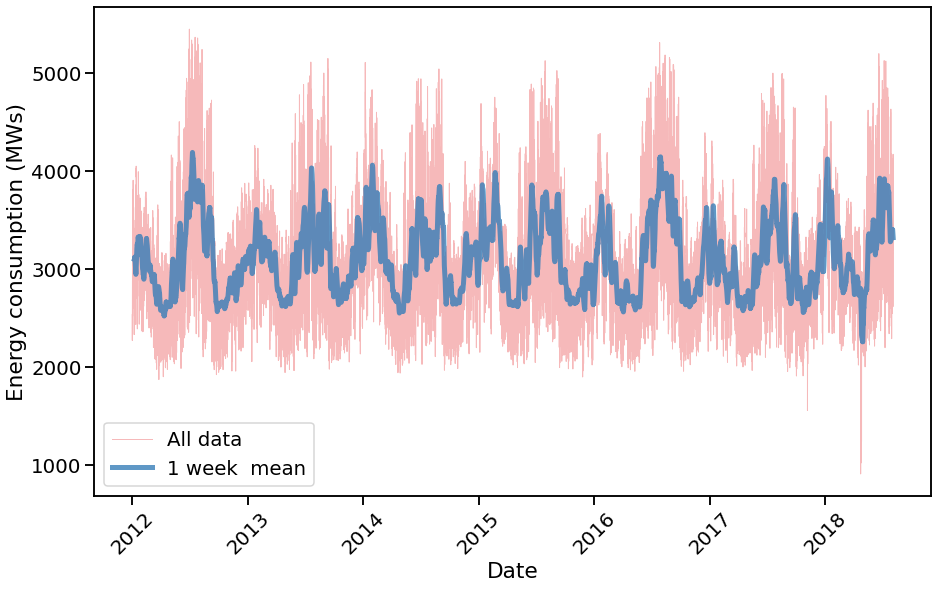

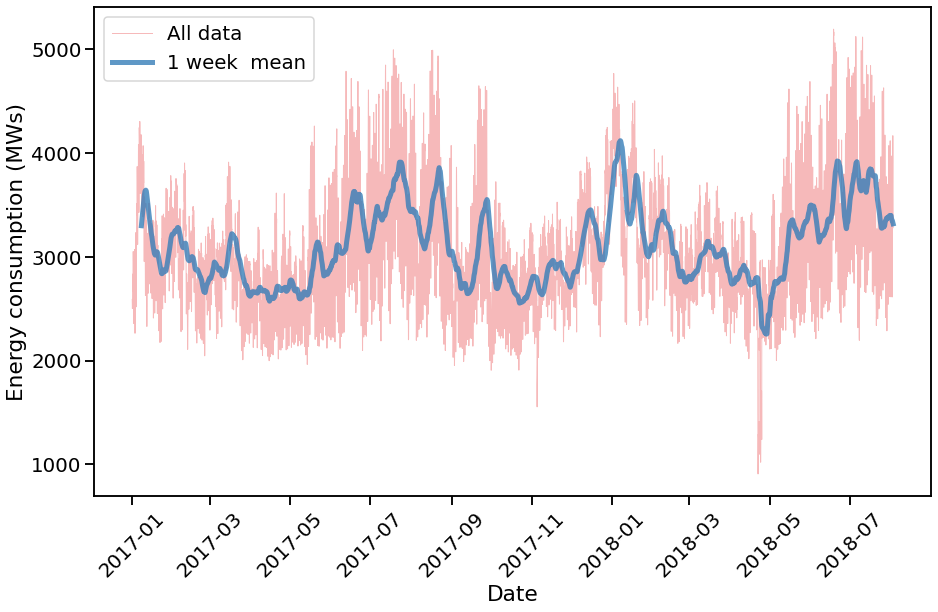

In [76]:

for df_tmp in [df, df.query('index > 2017')]:
        fig, ax = plt.subplots(figsize=(15, 9))
        ax.plot(df_tmp['MW'], label='All data', lw=1, color = 'C0', alpha = 0.3)
        ax.plot(
                df_tmp['MW'].rolling(24*7).mean(), color='C1',
                label='1 week  mean', zorder=3, alpha = 0.8, lw = 5,
                )
        ax.legend()
        ax.set_ylabel('Energy consumption (MWs)')
        ax.set_xlabel('Date')
        plt.xticks(rotation=45)


        plt.show()

#### High frequency consumption curve - related to daily routines and day/night cycle.

Explore January 2016

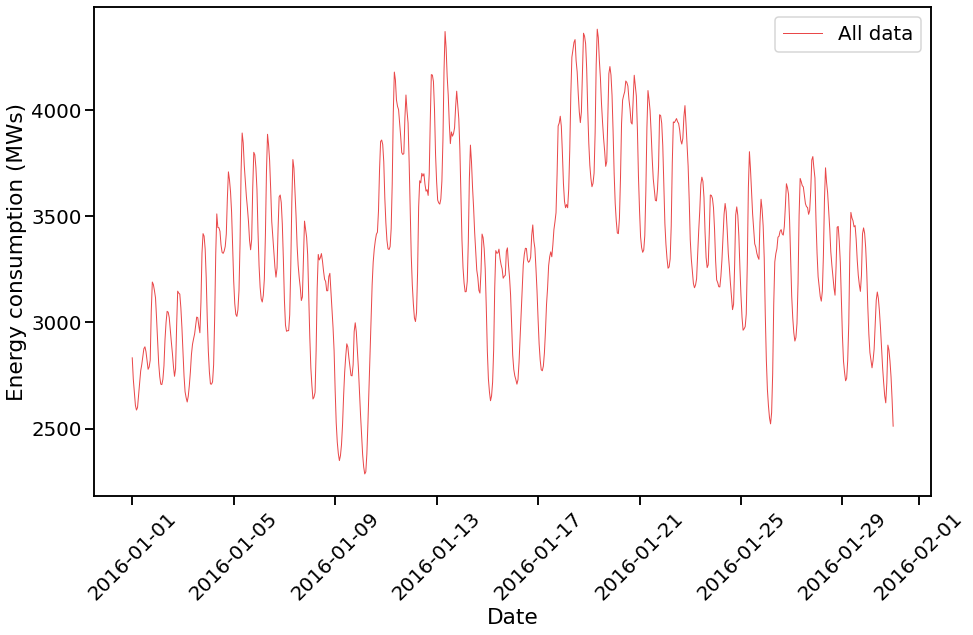

In [77]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(df[(df.index>='2016-01-01') & (df.index<='2016-01-31')]['MW'], label='All data', lw=1, color = 'C0', alpha = 0.8)
ax.legend()
ax.set_ylabel('Energy consumption (MWs)')
ax.set_xlabel('Date')
#rotate xticks
plt.xticks(rotation=45)
plt.show()

or average of many days in a few particular years (2013 and 2017)

we can see significant difference between daily patterns in the second month of the years 2013 and 2017 (Febriary 2013 and 2017)

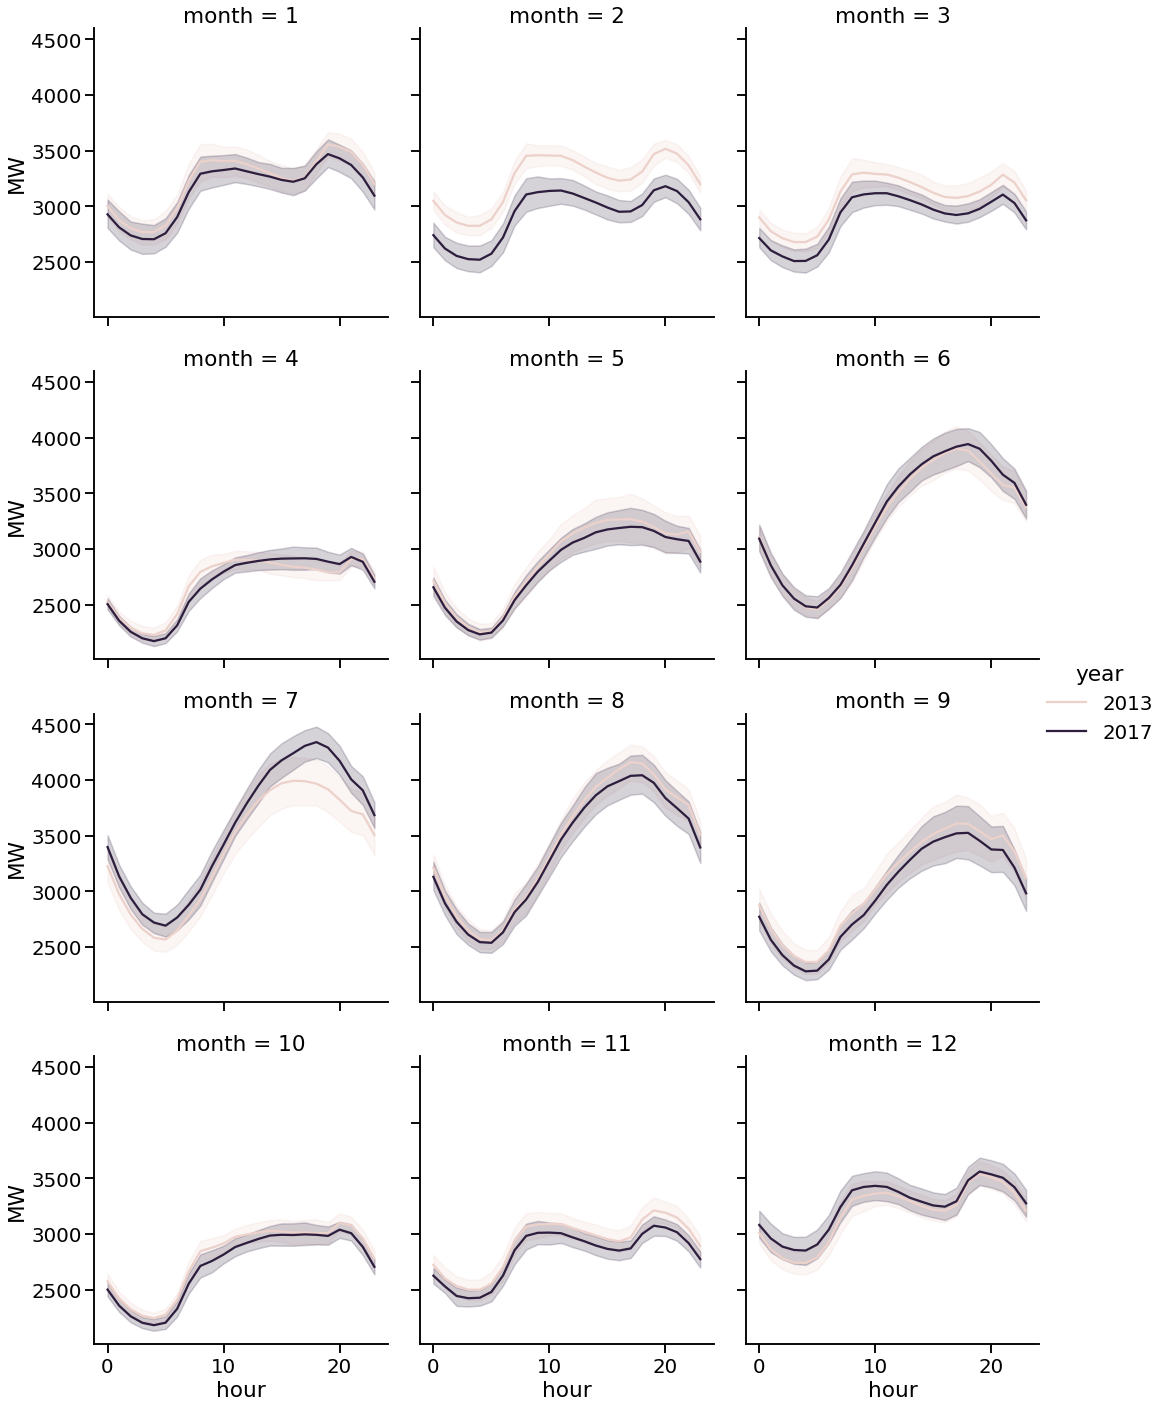

In [89]:
df['year'] = df.index.year
sns.relplot(data=df.query('year in [2013, 2017]'), x='hour', y='MW', kind='line', hue = 'year', col = 'month', col_wrap = 3, height = 5, aspect = 1)

In [108]:
# fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = False, gridspec_kw = {'hspace':0.4, 'height_ratios': None}, figsize = (12,12))


# for ax_tmp, df_tmp in zip(axs, [df.query('year == 2017 & month in [1,2]'), df.query('year == 2013 & month in [1,2] ')]):
#     ax_tmp.plot(df_tmp.index, df_tmp['MW'],  label=' data', lw=2,  alpha = 0.8)
#     ax_tmp.set_xlim(df_tmp.index[0], df_tmp.index[-1])
#     ax_tmp.set_ylabel('Energy consumption (MWs)')
#     ax_tmp.set_xlabel('Date')

#     #rotate xticks
#     for label in ax_tmp.get_xticklabels():
#         label.set_rotation(45)
    

In [109]:
df

,MW,dayofweek,hour,month,doy,year
dt,,,,,,
2012-01-01 01:00:00,2533.0,6,1,1,1,2012
2012-01-01 02:00:00,2465.0,6,2,1,1,2012
2012-01-01 03:00:00,2364.0,6,3,1,1,2012
2012-01-01 04:00:00,2313.0,6,4,1,1,2012
2012-01-01 05:00:00,2279.0,6,5,1,1,2012
...,...,...,...,...,...,...
2018-08-02 20:00:00,4052.0,3,20,8,214,2018
2018-08-02 21:00:00,3892.0,3,21,8,214,2018
2018-08-02 22:00:00,3851.0,3,22,8,214,2018


## Section 2: predictive model

above we created a set of features that we will use to predict the next hour's consumption. We will rely on time-related features: hour of the day, day of the week, and month of the year. So far we WILL NOT use the previous hours' consumption as a feature, since we want to isolate cycles from the local events.

In [5]:
def make_features(data, max_lag = None, rolling_mean_size = None):
    """
    Creates features based on the previous values of the target variable.
    Adds rolling mean.

    Args:
        data (pd.DataFrame): Dataframe with the target variable.
        max_lag (int): Maximum lag.
        rolling_mean_size (int): Size of the rolling mean window in hours.
    """    
    data = data.copy()
    data['dayofweek'] = data.index.dayofweek #0 for monday
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['doy'] = data.index.dayofyear
    #data['holiday'] = data.index.isin([5,6])

    if max_lag is not None:
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['MW'].shift(lag)

    if rolling_mean_size is not None:
        data['rolling_mean'] = data['MW'].shift().rolling(rolling_mean_size).mean()
    return data
#df_new = make_features(df, 1, 5)
df_new = make_features(df, None, None)
df_new = df_new.dropna()

#StandardScaler = StandardScaler()
#df_new = pd.DataFrame(StandardScaler.fit_transform(df_new), columns = df_new.columns, index = df_new.index)

df_new.head(10)

,MW,dayofweek,hour,month,doy
dt,,,,,
2015-01-01 00:00:00,3262.0,3,0,1,1
2015-01-01 01:00:00,3150.0,3,1,1,1
2015-01-01 02:00:00,3113.0,3,2,1,1
2015-01-01 03:00:00,3036.0,3,3,1,1
2015-01-01 04:00:00,3023.0,3,4,1,1
2015-01-01 05:00:00,3039.0,3,5,1,1
2015-01-01 06:00:00,3084.0,3,6,1,1
2015-01-01 07:00:00,3149.0,3,7,1,1
2015-01-01 08:00:00,3183.0,3,8,1,1


In [6]:

# ts_cv = TimeSeriesSplit(
#     n_splits=5,
#     gap=48,
#     max_train_size=10000,
#     test_size=1000,
# )
# all_splits = list(ts_cv.split(df))
# train_0, test_0 = all_splits[4]

In [7]:
#df_new = df_new[['MW']]
train, test = train_test_split(
        df_new, shuffle=False, test_size=.2, )

train = train.dropna()

train

,MW,dayofweek,hour,month,doy
dt,,,,,
2015-01-01 00:00:00,3262.0,3,0,1,1
2015-01-01 01:00:00,3150.0,3,1,1,1
2015-01-01 02:00:00,3113.0,3,2,1,1
2015-01-01 03:00:00,3036.0,3,3,1,1
2015-01-01 04:00:00,3023.0,3,4,1,1
...,...,...,...,...,...
2017-11-13 19:00:00,3349.0,0,19,11,317
2017-11-13 20:00:00,3315.0,0,20,11,317
2017-11-13 21:00:00,3242.0,0,21,11,317


In [8]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=300)


X_train = train.drop('MW', axis=1)
y_train = train['MW']
X_test = test.drop('MW', axis=1)
y_test = test['MW']


rf_reg.fit(X_train, y_train)


pred = rf_reg.predict(X_test)
pred_train = rf_reg.predict(X_train)


feature_importances = pd.DataFrame(
    rf_reg.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.sort_values('importance', ascending=False)

,importance
doy,0.508760
hour,0.363739
dayofweek,0.117479
month,0.010021


In [11]:
%matplotlib auto
fig,  ax =  plt.subplots( figsize = (19,12))
ax.plot(train.index, train['MW'], label='TRAIN')
ax.plot(train.index, pred_train, label='TRAIN PRED')

ax.plot(test.index, test['MW'], label='TEST')
ax.plot(test.index, pred, label='TEST PRED')
ax.legend()
ax.set_title('TEST')



fig, axs =  plt.subplots(nrows=4, ncols = 1, sharex = False, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (15,15))

inset_length = 24*7*2

axs[0].plot(train.index, train['MW'], label='TRAIN')
axs[0].plot(train.index, pred_train, label='TRAIN PRED')
axs[1].plot(train.index, train['MW'], label='TRAIN')
axs[1].plot(train.index, pred_train, label='TRAIN PRED')

axs[0].set_xlim(train.index[0], train.index[inset_length])
axs[1].set_xlim(train.index[-inset_length], train.index[-1])

axs[2].plot(test.index, test['MW'], label='TEST')
axs[2].plot(test.index, pred, label='TEST PRED')
axs[3].plot(test.index, test['MW'], label='TEST')
axs[3].plot(test.index, pred, label='TEST PRED')

axs[2].set_xlim(test.index[0], test.index[inset_length])
axs[3].set_xlim(test.index[-inset_length], test.index[-1])

for ax in axs:
    ax.legend()



Using matplotlib backend: MacOSX
